# Verification of AGM's CMPI6-HIST Simulation on Niagara 

Here, we use the [RTD tool](https://gitlab.com/CP4C/cp4c-docs/-/wikis/reference-runs) to compare the results of our CMPI6-historical simulation against the results of the same experiment as performed at CCCma ([click here to find the appropriate runid from CCCma's archive](https://gitlab.com/CP4C/cp4c-docs/-/wikis/reference-runs)). 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

TODO: better explanations and the paths ie. specify that this is if you're analyzing straight from $SCRATCH. Suggest changes if it's somewhere else either on your machine or on Trillium.  

In [2]:
base_path = "/scratch/agmorgan/agm-hist-benchmark-nia/output/{year}/nc_output/CMIP6/CMIP/CP4C/CanESM5-1/historical/r1i1p1f1/"
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# Total precip
ds_pr = xr.open_mfdataset(
    os.path.join(base_path.format(year='*'), 'Amon/pr/gn/v20190429/','pr_*.nc'),
    decode_times = time_coder,
    data_vars="all", 
)

# Convective precip
ds_prc = xr.open_mfdataset(
     os.path.join(base_path.format(year='*'), 'Amon/prc/gn/v20190429/','prc_*.nc'),
     decode_times = time_coder,
     data_vars="all", 
 )

In [3]:
ds_pr.pr

<xarray.DataArray 'pr' (time: 1968, lat: 64, lon: 128)> Size: 64MB
dask.array<concatenate, shape=(1968, 64, 128), dtype=float32, chunksize=(1, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2013-12-16 12:00:00
  * lat      (lat) float64 512B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    original_name:  PCP
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2025-08-15T04:43:10Z altered by CMOR: Reordered dimension...

## Initial Sanity Check

To start, let's just pick a time and plot the pr and prc to make sure the results aren't immediately concerning (ie. most of the convective precip. should lie occur at the tropics). 

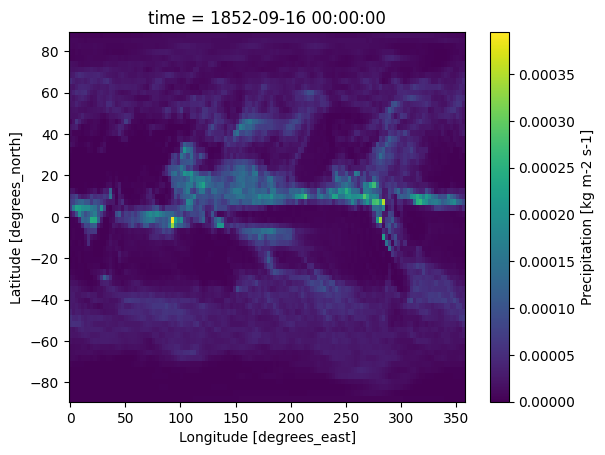

In [4]:
ds_pr.isel(time=32).pr.plot()

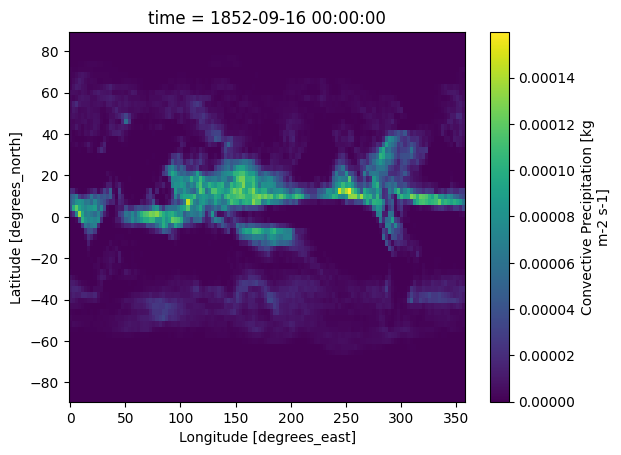

In [5]:
ds_prc.isel(time=32).prc.plot()

With this basic check done, we move on to comparing the time series for mean annual precipitation against existing runs. 

## Time Series Checks

Note that we take the *spatial* mean of pr and prc (weighted by grid cell area), then take the mean over time. 

First, we'll compute some areas required to take the spatial mean. Next, we show results for pr. After that, we repeat the process for prc. 

In [6]:
ds_areacella = xr.open_dataset(base_path.format(year='1850') + '/fx/areacella/gn/v20190429/areacella_fx_CanESM5-1_historical_r1i1p1f1_gn.nc')
global_area = ds_areacella.areacella.sum(dim=['lon', 'lat'])                         # Global area

np.float32(2.8452172)

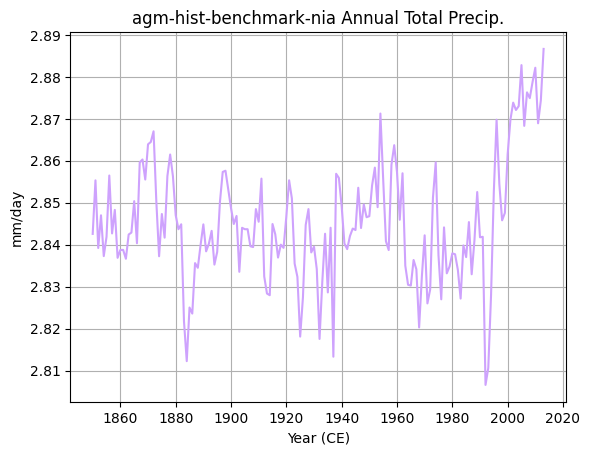

In [7]:
pr_gm = (ds_areacella.areacella * ds_pr.pr).sum(dim=['lon', 'lat']) / global_area # Properly area weighted mean of rate of flux
time_scale = 60*60*24 # Number of seconds in a day 
(time_scale*pr_gm.groupby('time.year').mean(dim='time')).plot(color="xkcd:lilac")
plt.grid()
plt.title("agm-hist-benchmark-nia Annual Total Precip.")
plt.xlabel("Year (CE)")
plt.ylabel("mm/day")
pr_mean = time_scale*pr_gm.mean(dim='time').values
pr_mean

And here is what we get from the reference runs: 

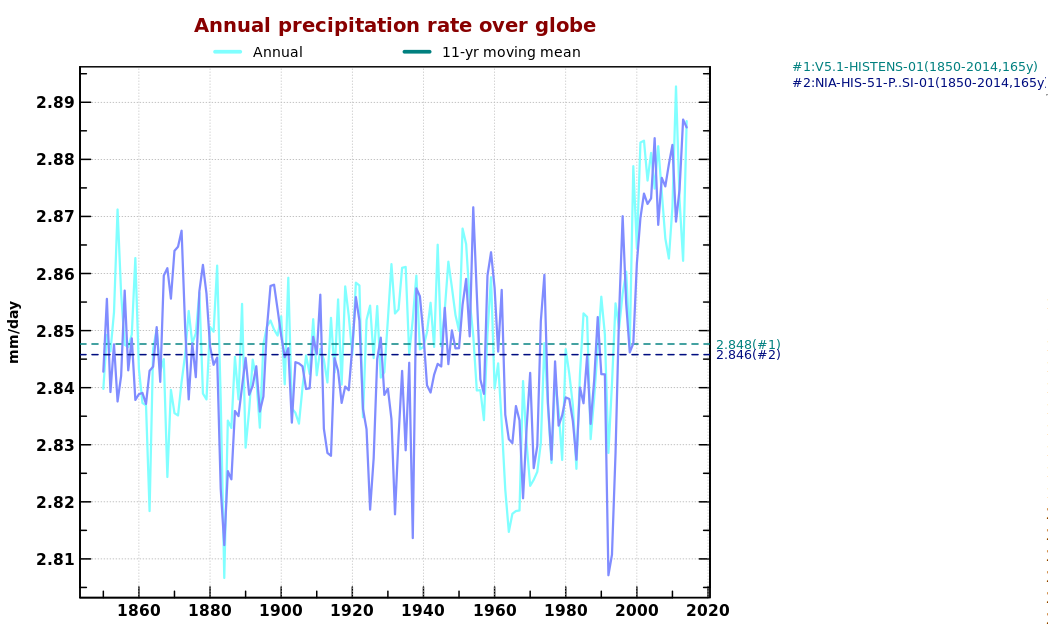

Note that our results agree with the Niagara alpha test run, but both Niagara runs disagree w/ the CCCma run. This is noted in the CP4C wiki, and we can see that it affects the mean precip. rate only negligibly. 

np.float32(1.1091385)

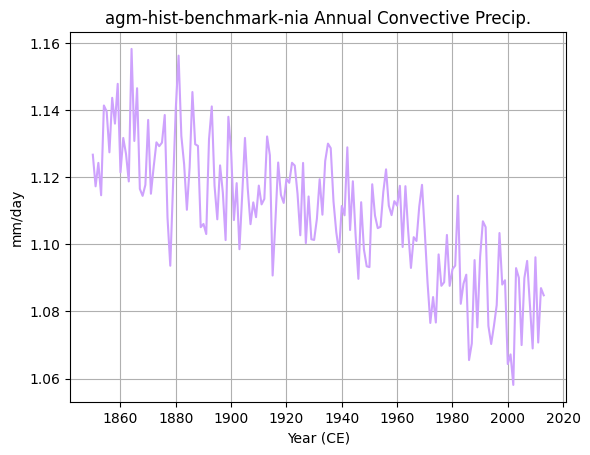

In [8]:
prc_gm = (ds_areacella.areacella * ds_prc.prc).sum(dim=['lon', 'lat']) / global_area # Properly area weighted mean of rate of flux
time_scale = 60*60*24 # Number of seconds in a day 
(time_scale*prc_gm.groupby('time.year').mean(dim='time')).plot(color="xkcd:lilac")
plt.grid()
plt.title("agm-hist-benchmark-nia Annual Convective Precip.")
plt.xlabel("Year (CE)")
plt.ylabel("mm/day")
prc_mean = time_scale*prc_gm.mean(dim='time').values
prc_mean

# TODO: write a little function to deal w/ the mean stuff & make the code cleaner... be a good example to future students!

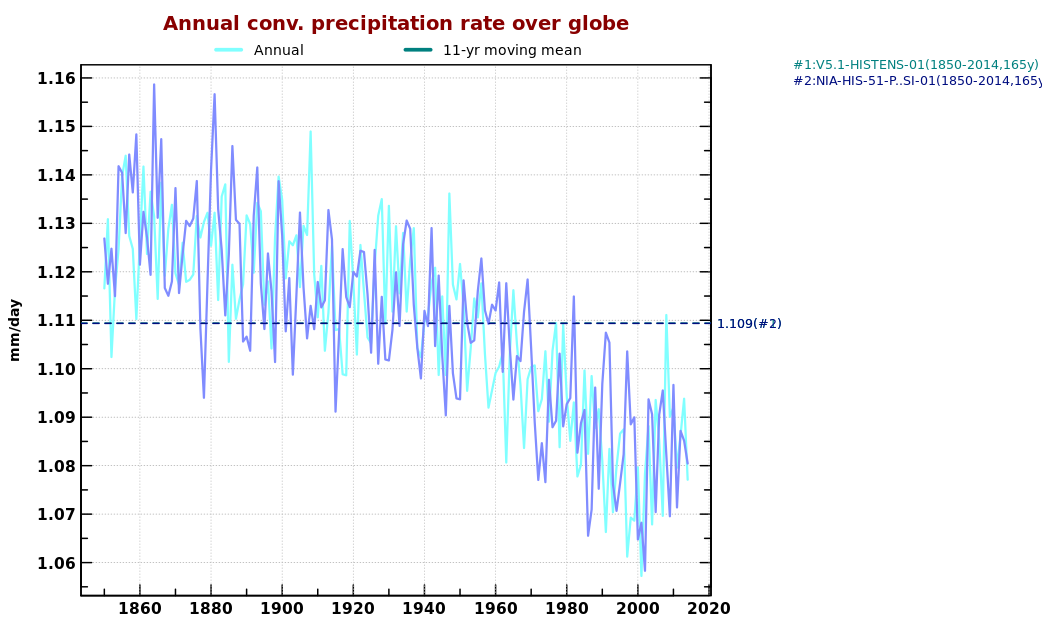

Again, we see excellent agreement w/ the Niagara run and mild disagreement w/ the CCCma run. 

## Loading the Daily Results 

Even though we don't have RTD records readily available when it comes to *daily* precipitation, it's worth at least loading the daily precipitation for 1980-2000 just to make sure we understand the directory structure.

In [9]:
daily_path = 'day/prc/gn/v20190429/prc_day_CanESM5-1_historical_r1i1p1f1_gn_{year}0101-{year}1231.nc'

# Convective precip 
ds_prc_daily = xr.open_mfdataset(
     [os.path.join(base_path.format(year=my_year), daily_path.format(year=my_year)) for my_year in range(1980, 2001)],
     decode_times = time_coder,
     data_vars = "all", 
 )

In [10]:
prc_daily_gm = (ds_areacella.areacella * ds_prc_daily.prc).sum(dim=['lon', 'lat']) / global_area # Properly area weighted mean of rate of flux

np.float32(1.08735)

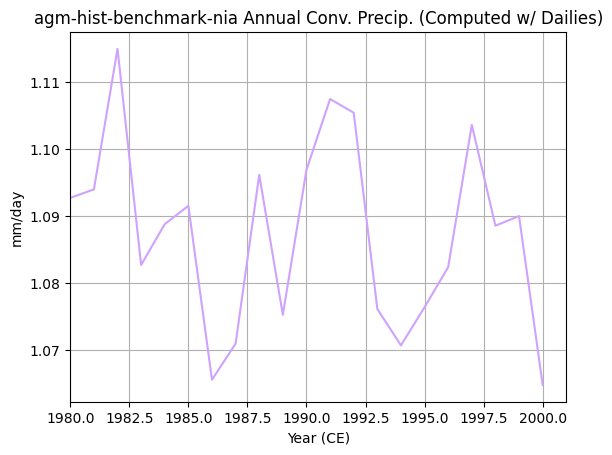

In [11]:
(time_scale*prc_daily_gm.groupby('time.year').mean(dim='time')).plot(color="xkcd:lilac")
plt.grid()
plt.title("agm-hist-benchmark-nia Annual Conv. Precip. (Computed w/ Dailies)")
plt.xlabel("Year (CE)")
plt.ylabel("mm/day")
plt.xlim([1980,2001])
prc_daily_mean = time_scale*prc_daily_gm.mean(dim='time').values
prc_daily_mean

And here is a zoomed-in version of the RTD benchmark runs for comparison... 

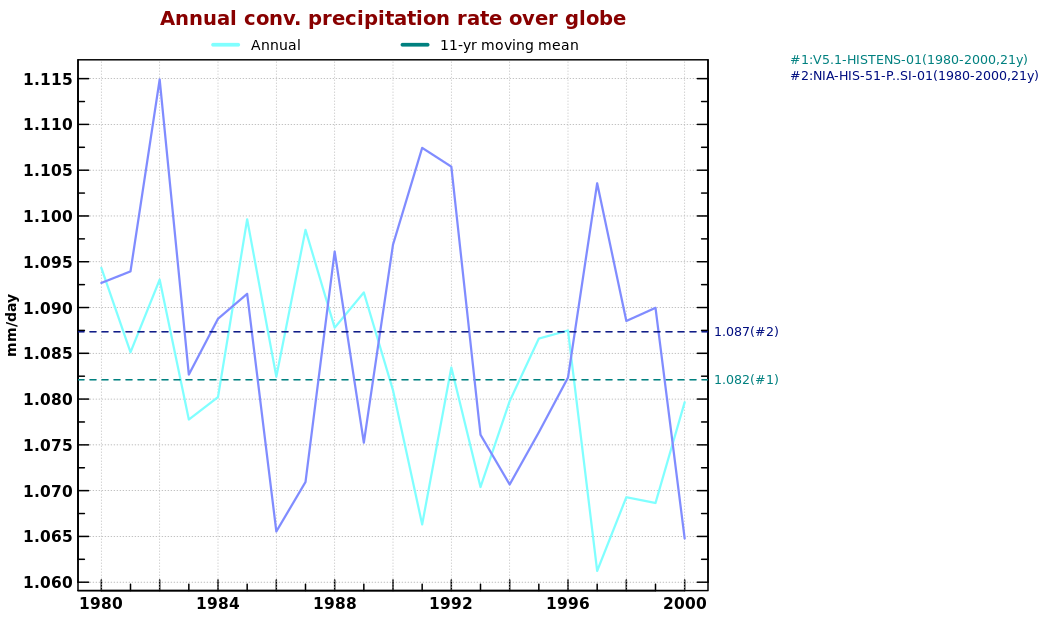

So, we can be confident that our run data is sensible! 